# New York City Parking Ticket Analysis

In [1]:
from IPython.display import HTML
#Instruction for hiding the code section for presentation
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
%matplotlib inline 

##### Preparation: Raw_data loading

In [3]:
#set fiscal year and load the dataset of chosen
year = 2016
filename = "Parking_Violations_Issued_-_Fiscal_Year_" + str(year) + ".csv"
print("loading data", filename, "...")
raw_data = pd.read_csv(filename, low_memory = False)
print("done!")

loading data Parking_Violations_Issued_-_Fiscal_Year_2016.csv ...
done!


In [4]:
#NYC fiscal year starts from July to June next year
start_date = str(year-1) + "-07-01"
end_date = str(year) + "-06-30"

#### 1. Overview - Distribution of parking tickets issued over the fiscal year.

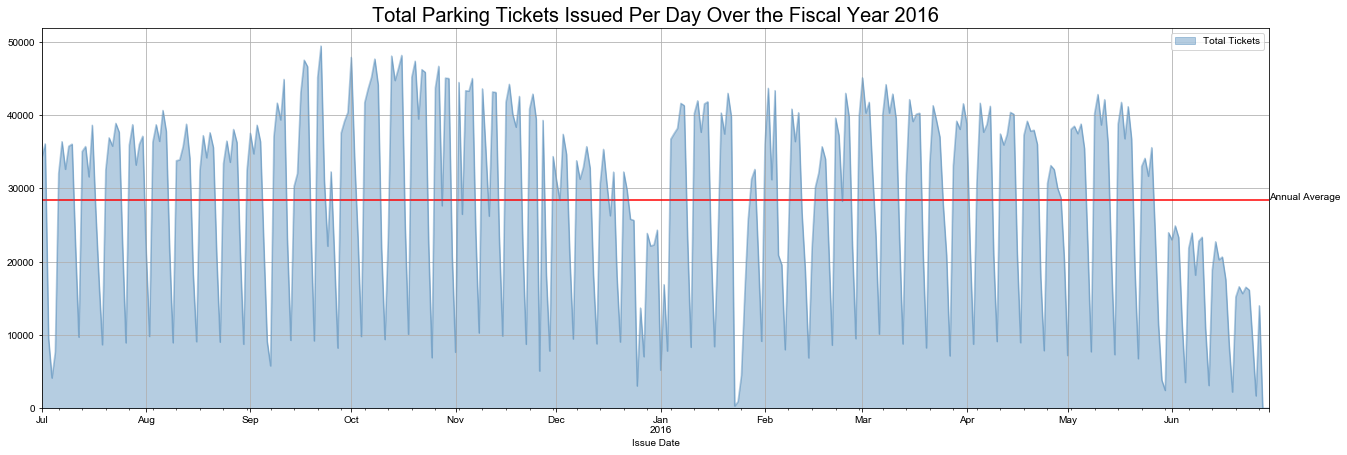

In [5]:
#Data Cleaning Section
Date_SNum = raw_data[['Issue Date','Summons Number']]
Date_SNum = Date_SNum.groupby('Issue Date', as_index = False).count() 
Date_SNum['Issue Date'] = pd.to_datetime(Date_SNum['Issue Date'])
Date_SNum = Date_SNum.set_index('Issue Date')
Date_SNum = Date_SNum.loc[start_date : end_date]#Select the tickets issued inside the fiscal year range
Date_SNum = Date_SNum.sort_index()
Date_Total = Date_SNum.rename(columns = {"Summons Number" : "Total Tickets"})

#Graph Section
fig1 = plt.figure(figsize = (22,7))
ax1 = fig1.add_subplot(1,1,1)
Date_Total.plot(ax = ax1, kind = 'area', color = 'steelblue', alpha = 0.4, grid = True)
plt.title("Total Parking Tickets Issued Per Day Over the Fiscal Year " + str(year), fontsize = 20 )
ax1.hlines(y = Date_Total['Total Tickets'].mean(), xmin = start_date, xmax = end_date, color = 'r', )
plt.text(end_date, Date_Total['Total Tickets'].mean(), "Annual Average")
sns.set_style('dark')

#### 2. Distribution of the Traffic Tickets Issued on Different Day of the Week and Each Month

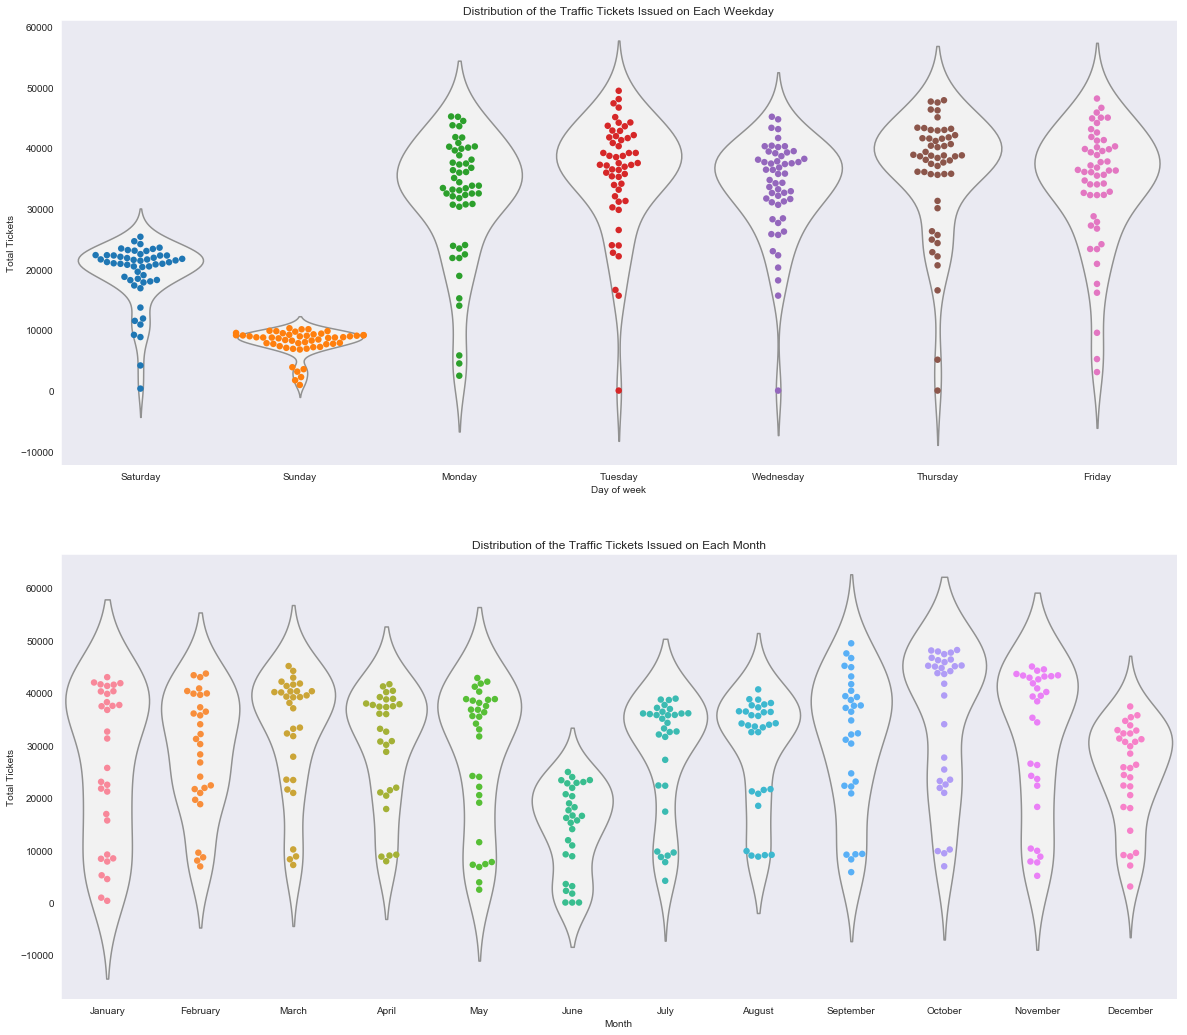

In [6]:
Date_Total["Day of week"] = Date_Total.index.day_name()
Date_Total["Month"] = Date_Total.index.month_name()

fig2, axes = plt.subplots(2,1, figsize = (20,18))
sns.set_style("dark")
#violin plot for the number of tickets gave out on each weekday
sns.violinplot(ax = axes[0], x = "Day of week", y = "Total Tickets", data = Date_Total, height = 5, width = 0.8, aspect = 13/5, order = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"], scale = 'count', inner = None, color = "0.95")
sns.swarmplot(ax = axes[0], x = "Day of week", y = "Total Tickets", data = Date_Total, order = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"], size = 6.5)
axes[0].set_title('Distribution of the Traffic Tickets Issued on Each Weekday')

#violin plot for the number of tickets gave out on each weekday
sns.violinplot(ax = axes[1], x = "Month", y = "Total Tickets", data = Date_Total, height = 5, width = 0.9, aspect = 13/5, order = ["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], scale = "count", inner = None, color = "0.95")
sns.swarmplot(ax = axes[1], x = "Month", y = "Total Tickets", data = Date_Total, order = ["January", "February", "March", "April", "May", "June", "July","August","September","October","November","December"], size = 6.5)
axes[1].set_title('Distribution of the Traffic Tickets Issued on Each Month')
sns.set_style('darkgrid')

#### 3. Total Ticket Issued on Different Hours of the Day

In [7]:
#Function to clean the Violatime input, it will convert '1000P' original entry to a integer 2200. If invalid character
#presents, return 9999
def cleanViolationTime(input):
    try:
        h, m, A_P = int(input[0:2]), int(input[2:4]), input[4]
        if A_P not in ['A','P']:
            return -1
        else:
            if A_P == 'P':
                if h == 12:
                    h = 0
                h = (h + 12)*60
            if A_P == 'A' and h == 12:
                h = 0
            if A_P == 'A': 
                h = h*60
            return (h + m)
    except:
        return -1

In [8]:
#Cleanning the dataset
hour_data = raw_data[['Violation Time', 'Summons Number']]
hour_data = hour_data.groupby('Violation Time', as_index = False).count()
hour_data = hour_data.loc[hour_data['Summons Number'] > 10] #I found this is a very effective way to filter all invalid data entries since they are all infrequent events.
hour_data = hour_data.rename(columns = {'Summons Number' : 'Total Tickets'})
hour_data['Cleaned Violation Time'] = hour_data['Violation Time'].apply(cleanViolationTime)
hour_data['Cleaned Violation Time'] = hour_data['Cleaned Violation Time'].astype('timedelta64[m]')
hour_data = hour_data.groupby('Cleaned Violation Time').sum()
hour_data.index = hour_data.index.map(str)

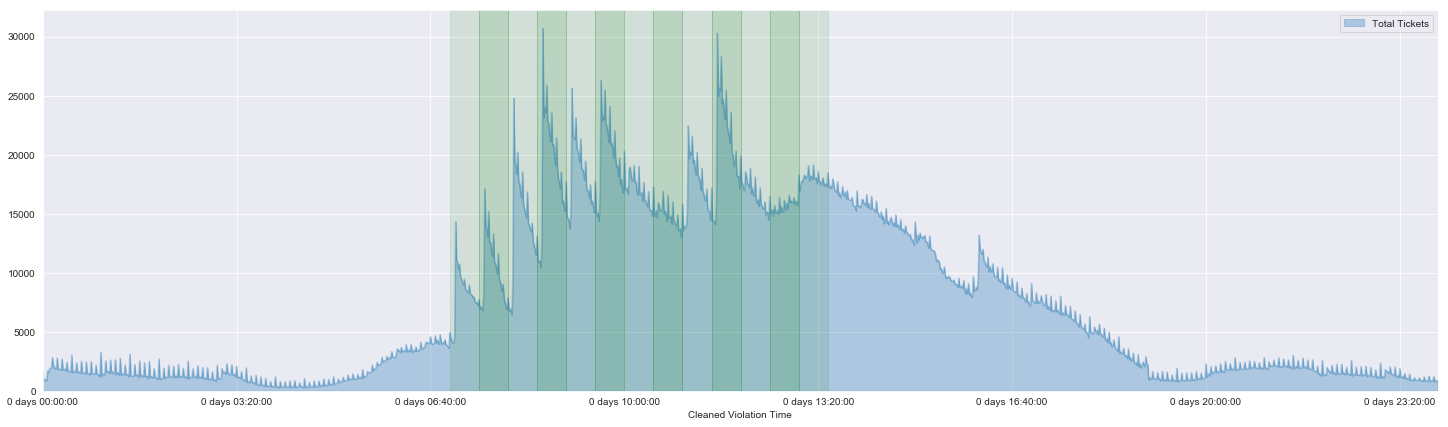

In [9]:
fig1 = hour_data.plot(kind = 'area', figsize = (25,7), grid = True, alpha = 0.3)
for i in range(13):
    if i % 2 == 0:
        fig1.axvspan(420 + i*30,420 + (i+1)*30, alpha = 0.1, color = 'g') #7am to 12om
    else:
        fig1.axvspan(420 + i*30,420 + (i+1)*30, alpha = 0.2, color = 'g') #7am to 12om





#### 4. Tickets Issued for Different Plate Types

Text(205.0, 0.5, 'Month Number')

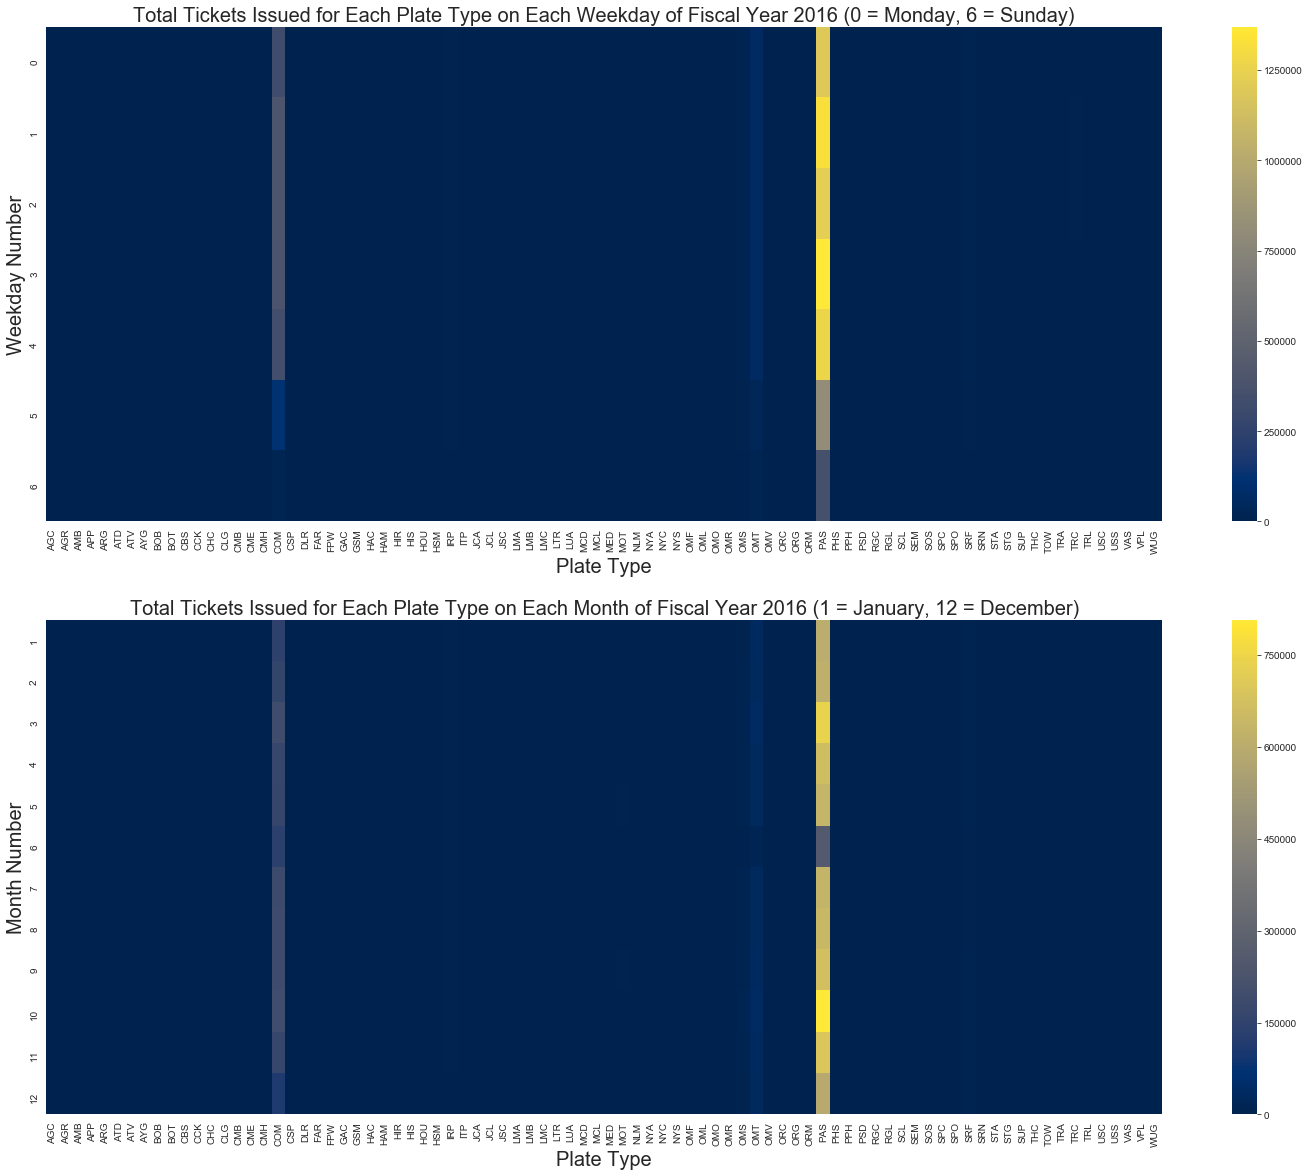

In [10]:
#Prepare the dataset
Date_PT_TotalTX = raw_data[['Issue Date','Plate Type','Summons Number']]
Date_PT_TotalTX = Date_PT_TotalTX.fillna("not_valid")
Date_PT_TotalTX = Date_PT_TotalTX.groupby(['Issue Date','Plate Type'], as_index = False).count()
Date_PT_TotalTX['Issue Date'] = pd.to_datetime(Date_PT_TotalTX['Issue Date'])
Date_PT_TotalTX = Date_PT_TotalTX.set_index('Issue Date')
Date_PT_TotalTX = Date_PT_TotalTX.loc[start_date:end_date]
Date_PT_TotalTX = Date_PT_TotalTX.loc[Date_PT_TotalTX['Plate Type'] != '999']
Date_PT_TotalTX['Month Number'] = Date_PT_TotalTX.index.month
Date_PT_TotalTX['Weekday Number'] = Date_PT_TotalTX.index.weekday
Weekday_PT_TotalTX = Date_PT_TotalTX.groupby(['Weekday Number', 'Plate Type']).sum()
Month_PT_TotalTX = Date_PT_TotalTX.groupby(['Month Number','Plate Type']).sum()

#Tranform the table for heat plot
Weekday_PT_TotalTX = Weekday_PT_TotalTX.reset_index()
Month_PT_TotalTX = Month_PT_TotalTX.reset_index()
Weekday_PT_TotalTX = Weekday_PT_TotalTX.pivot(index = 'Weekday Number', columns = 'Plate Type', values = 'Summons Number')
Weekday_PT_TotalTX = Weekday_PT_TotalTX.fillna(0)
Month_PT_TotalTX = Month_PT_TotalTX.pivot(index='Month Number', columns='Plate Type', values='Summons Number')
Month_PT_TotalTX = Month_PT_TotalTX.fillna(0)

#Making Heatmap
fig3, axes = plt.subplots(2,1, figsize=(25,20)) 
sns.heatmap(ax = axes[0], data = Weekday_PT_TotalTX, cmap = "cividis")
axes[0].set_title("Total Tickets Issued for Each Plate Type on Each Weekday of Fiscal Year " + str(year) + " (0 = Monday, 6 = Sunday)",fontsize = 20)
axes[0].set_xlabel("Plate Type", fontsize = 20)
axes[0].set_ylabel("Weekday Number", fontsize = 20)
sns.heatmap(ax = axes[1], data = Month_PT_TotalTX, cmap = "cividis")
axes[1].set_title("Total Tickets Issued for Each Plate Type on Each Month of Fiscal Year " + str(year) + " (1 = January, 12 = December)",fontsize = 20 )
axes[1].set_xlabel("Plate Type", fontsize = 20)
axes[1].set_ylabel("Month Number", fontsize = 20)

#### 5. violation code with Plate Types

In [11]:
#Create a sub-data set
Date_VCode_PT_TotalTX = raw_data[['Issue Date','Violation Code','Plate Type','Summons Number']]
Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.fillna("not_valid") 
Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.groupby(['Issue Date','Plate Type','Violation Code'], as_index = False).count()
Date_VCode_PT_TotalTX['Issue Date'] = pd.to_datetime(Date_VCode_PT_TotalTX['Issue Date'])
Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.set_index('Issue Date')
Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.loc[start_date:end_date]
Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.loc[Date_VCode_PT_TotalTX['Plate Type'] != '999']
Date_VCode_PT_TotalTX = Date_VCode_PT_TotalTX.loc[Date_VCode_PT_TotalTX['Violation Code'] != 0]

VCode_PT_TotalTX = Date_VCode_PT_TotalTX.groupby(['Violation Code', 'Plate Type']).sum().reset_index()
VCode_PT_TotalTX = VCode_PT_TotalTX.fillna(0)
VCode_PT_TotalTX = VCode_PT_TotalTX.rename(columns = {'Summons Number' : 'Total Tickets'})

Text(205.0, 0.5, 'Violation Code')

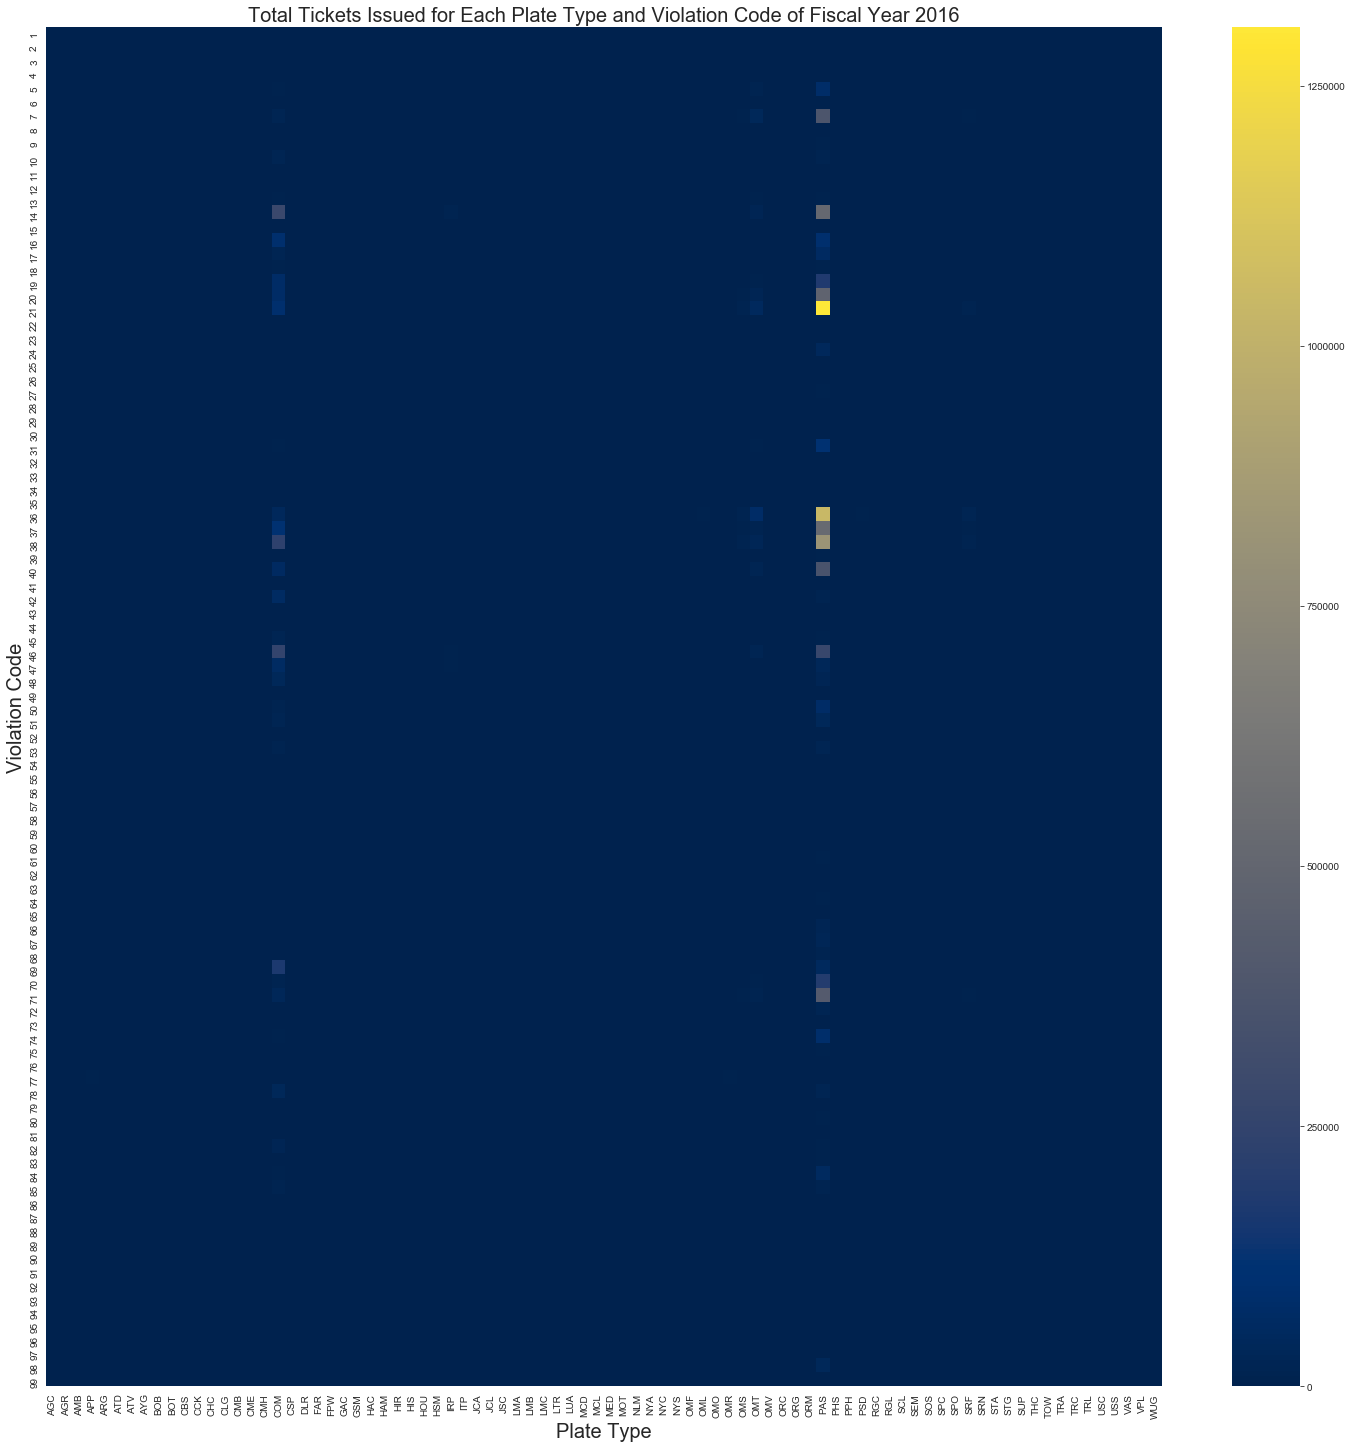

In [12]:
#All violation codes
fig, ax = plt.subplots(1,1, figsize = (25,25))
VCode_PT_TotalTX_all = VCode_PT_TotalTX.pivot(index='Violation Code', columns='Plate Type', values='Total Tickets')
VCode_PT_TotalTX_all = VCode_PT_TotalTX_all.fillna(0)
sns.heatmap(ax = ax, data = VCode_PT_TotalTX_all, cmap = "cividis")
ax.set_title("Total Tickets Issued for Each Plate Type and Violation Code of Fiscal Year " + str(year) ,fontsize = 20)
ax.set_xlabel("Plate Type", fontsize = 20)
ax.set_ylabel("Violation Code", fontsize = 20)

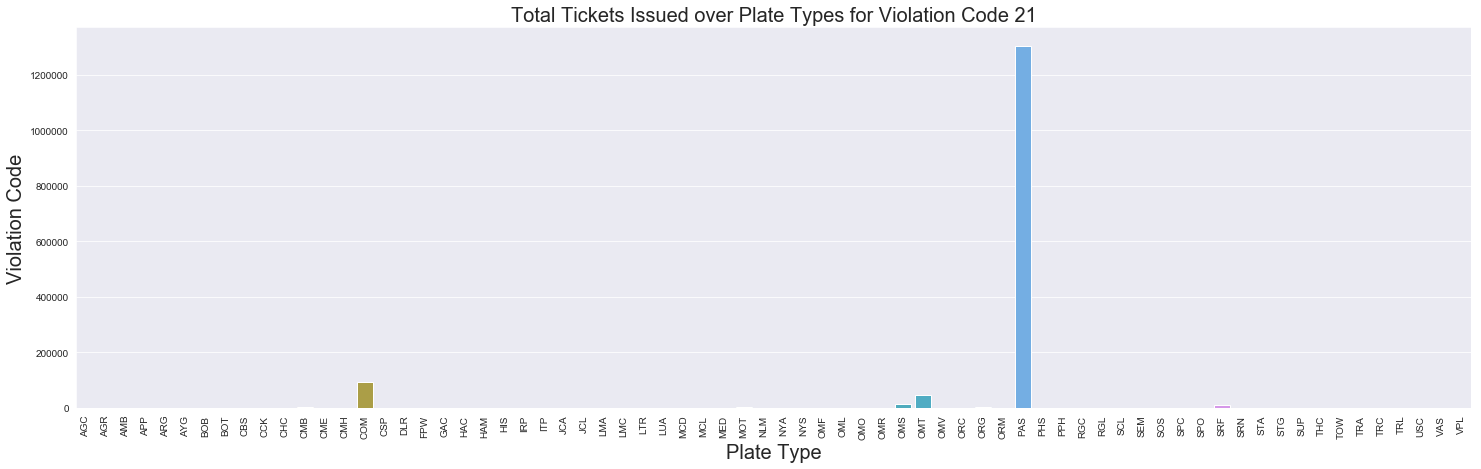

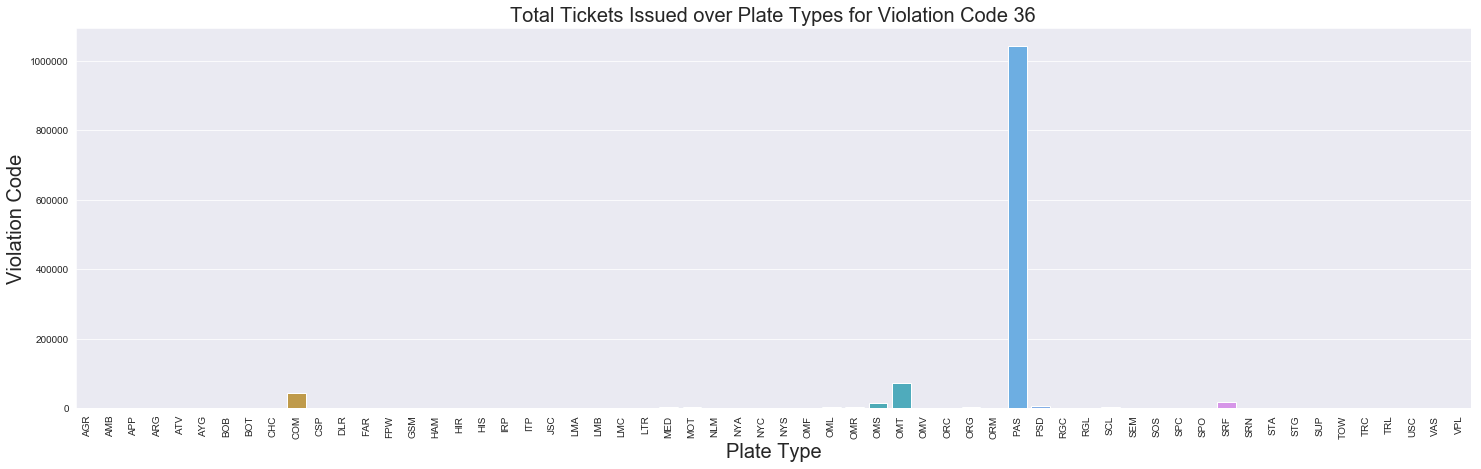

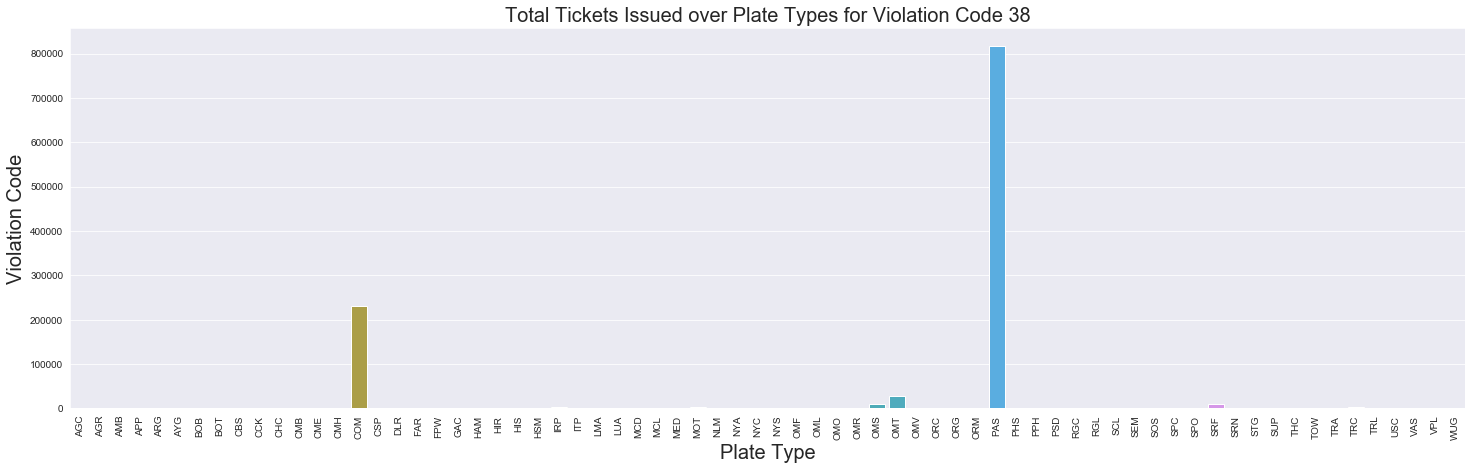

In [14]:
#individual violation code
for i in [21,36,38]:
    selected_df = VCode_PT_TotalTX.loc[VCode_PT_TotalTX['Violation Code'] == i]
    fig, ax = plt.subplots(1,1, figsize = (25,7))
    sns.set_style("darkgrid")
    sns.barplot(x = 'Plate Type', y = 'Total Tickets', data = selected_df)
    ax.set_title("Total Tickets Issued over Plate Types for Violation Code " + str(i) ,fontsize = 20)
    ax.set_xlabel("Plate Type", fontsize = 20)
    ax.set_ylabel("Violation Code", fontsize = 20)
    ax = ax.set_xticklabels(selected_df['Plate Type'], rotation=90, ha = 'center')

#### 6.  Plate Type = PAS, Violation Code = 21

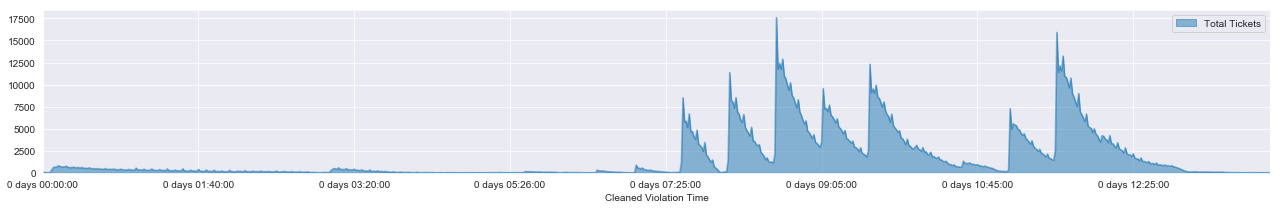

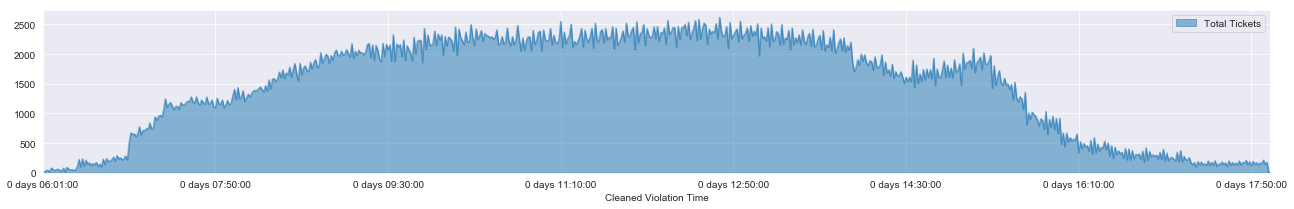

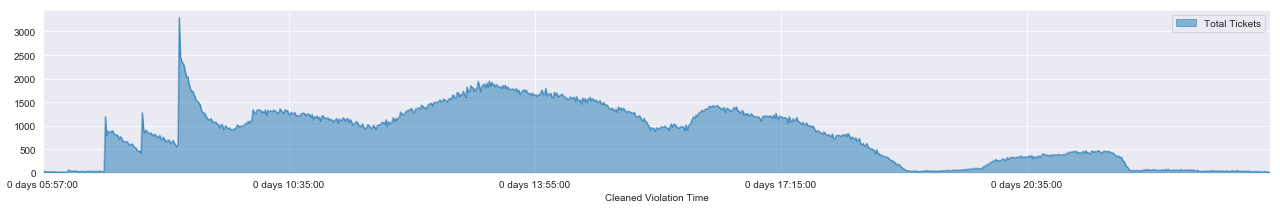

In [15]:
for i in [21,36,38]:
    PAS_hour_data = raw_data[['Violation Time', 'Summons Number', 'Violation Code', 'Plate Type']]
    PAS_hour_data = PAS_hour_data.loc[PAS_hour_data['Plate Type'] == 'PAS']
    PAS_hour_data = PAS_hour_data.loc[PAS_hour_data['Violation Code'] == i]
    PAS_hour_data = PAS_hour_data.groupby('Violation Time', as_index = False).count()
    PAS_hour_data = PAS_hour_data.loc[PAS_hour_data['Summons Number'] > 10] #I found this is a very effective way to filter all invalid data entries since they are all infrequent events.
    PAS_hour_data = PAS_hour_data.rename(columns = {'Summons Number' : 'Total Tickets'})
    PAS_hour_data['Cleaned Violation Time'] = PAS_hour_data['Violation Time'].apply(cleanViolationTime)
    PAS_hour_data['Cleaned Violation Time'] = PAS_hour_data['Cleaned Violation Time'].astype('timedelta64[m]')
    PAS_hour_data = PAS_hour_data.groupby('Cleaned Violation Time').sum()
    PAS_hour_data.index = PAS_hour_data.index.map(str)
    PAS_hour_data=PAS_hour_data[['Total Tickets']]
    fig2 = PAS_hour_data.plot(figsize = (22,3), grid = True, kind = 'area', alpha = 0.5)
    sns.set_style('darkgrid')

#### 7. Total Tickets Issued by Each Precinct of NYC 

Text(0.5, 1.0, 'Total Tickets Issued by Each Precinct of NYC in Fiscal Year 2016')

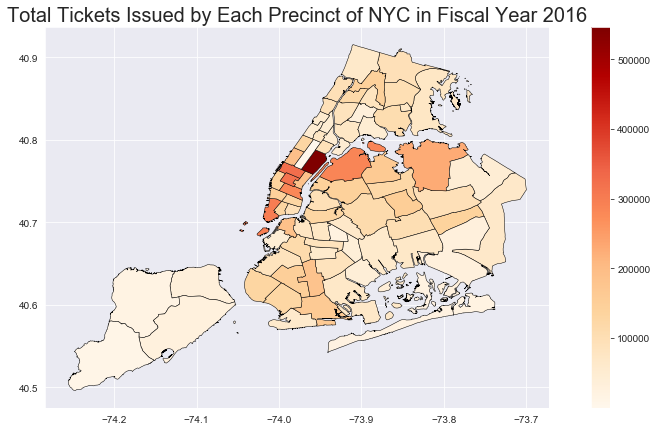

In [16]:
Date_Precinct_TotalTX = raw_data[['Issue Date','Violation Precinct','Summons Number']]
#Group data based on issue date and precinct
Date_Precinct_TotalTX = Date_Precinct_TotalTX.groupby(['Issue Date','Violation Precinct'], as_index = False).count()
Date_Precinct_TotalTX['Issue Date'] = pd.to_datetime(Date_Precinct_TotalTX['Issue Date'])
Date_Precinct_TotalTX = Date_Precinct_TotalTX.set_index('Issue Date')
#locate data within the approporiate fiscal year range
Date_Precinct_TotalTX = Date_Precinct_TotalTX[start_date:end_date]
#Group data base on precinct
Precinct_TotalTX = Date_Precinct_TotalTX.groupby('Violation Precinct').sum()
#remove invalid precinct entries
Precinct_TotalTX = Precinct_TotalTX[1:124]
Precinct_TotalTX = Precinct_TotalTX.drop([2,3,4,8,11,12,15,16,21,27,29,31,35,36,37,38,39,51,53,54,55,56,57,58,59,64,65,74,80,82,85,86,87,89,91,92,93,95,96,97,98,99,116,117,118,119])

#Precinct Heat Map
map_path = "./precinct_map/geo_export_1ac7dc26-ca74-4ae0-8bef-28d6099c5e96.shp"
data = gpd.read_file(map_path)
data = data.set_index('precinct')
data = pd.concat([data,Precinct_TotalTX], axis = 1)
fig, ax = plt.subplots(1, 1, figsize = (15,7))
data.plot(column='Summons Number', legend=True, ax = ax, cmap = 'OrRd',linewidth = 0.5, edgecolor = 'k')
ax.set_title("Total Tickets Issued by Each Precinct of NYC in Fiscal Year " + str(year), Fontsize = 20)